# Определение перспективного тарифа для телеком-компании

## Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Откроем файлы с данными и изучим общую информацию.

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv', index_col=0)
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
calls.info()
calls.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
49752,1123_771,2018-03-27,0.00,1123
152050,1379_285,2018-08-20,7.98,1379
163393,1402_216,2018-10-15,5.28,1402
54460,1136_69,2018-11-22,12.67,1136
67252,1171_277,2018-06-18,5.52,1171


In [4]:
internet.info()
internet.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
4809,1014_415,0.00,2018-07-06,1014
39219,1136_66,578.83,2018-12-01,1136
62843,1213_225,146.18,2018-10-12,1213
4304,1012_577,178.90,2018-09-04,1012
132145,1439_262,511.34,2018-08-10,1439


In [5]:
messages.info()
messages.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
21718,1091_271,2018-05-24,1091
35265,1150_445,2018-10-28,1150
75453,1319_42,2018-12-12,1319
58899,1257_691,2018-12-05,1257
8057,1032_228,2018-03-29,1032


In [6]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
users.info()
users.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
119,1119,53,NaN,Петрозаводск,Олег,Сухарев,2018-04-22,smart
424,1424,27,NaN,Москва,Розалия,Ёрохова,2018-06-20,ultra
490,1490,30,NaN,Москва,Радомир,Алесин,2018-04-03,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
88,1088,58,NaN,Казань,Веселина,Андреенко,2018-06-04,smart


Данные разбиты на 5 таблиц, на первый взгляд информация в таблицах корректна, некоторые столбцы требуют замены типа данных. Прорусков нет (кроме столбца с информацией о прекращении пользования тарифом, но это не ошибка). Также можно проверить данные на скрытые дубликаты.

## Предобработка данных

### Замена типа данных

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

Округлим время звонка в большую сторону, т.к. «Мегалайн» всегда округляет секунды до минут.

In [9]:
calls['duration'] = np.ceil(calls['duration'])

Переведем лимит по Мб в ГБ в таблице с тарифами.

In [10]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included', 
                   'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff_name']

### Работа с дубликатами

Поищем дубликаты.

In [11]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [12]:
users['user_id'].duplicated().sum()

0

Дубликатов нет.

### Расчеты для каждого пользователя по месяцам

Так как в дальнейшем для анализа нам понадобятся данные по месяцам, добавим в таблицы с информацией о звонках, сообщениях и интернет-траффике в соответсвующие столбцы.

In [13]:
calls['month'] = calls['call_date'].astype('datetime64[M]')
messages['month'] = messages['message_date'].astype('datetime64[M]')
internet['month'] = internet['session_date'].astype('datetime64[M]')

Посмотрим распределение интернет-траффика и израсходованных минут разговора.

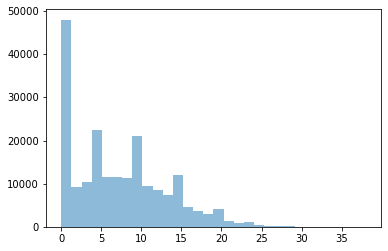

In [14]:
plt.hist(calls['duration'], bins=30, alpha = 0.5)
plt.show()

Есть пики на 0 (возможно, симкарту не используют для звонков), 5-10-15-20 - доподлинно неизвестно, чем вызваны пики, предположим, что особенностями фиксирования звонков.

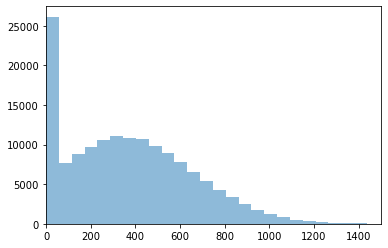

In [15]:
plt.xlim(0, 1500)
plt.hist(internet['mb_used'], bins=30, alpha = 0.5)
plt.show()

Присутсвует пик на нулевых зеачениях. Опять же, интеренетом могут не пользоваться и использовать симкарту для звонков. В любом случае, дальнейший анализ наличие нулей никак не исказит, поэтому оставим их.

- Расчитаем по месяцам количество сделанных звонков и израсходованных минут разговора

Для этого сделаем сводную таблицу по пользователям и месяцам, с подсчетом израсходованных минут и количеством звонков.

In [16]:
pivot_calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
pivot_calls.columns = ['calls_quantity', 'calls_duration']
pivot_calls.sample(5)

,,calls_quantity,calls_duration
user_id,month,,
1460,2018-10-01,96,711.0
1060,2018-11-01,46,371.0
1189,2018-01-01,7,51.0
1482,2018-08-01,42,331.0
1159,2018-11-01,10,85.0


- Расчитаем по месяцам количество отправленных сообщений

In [17]:
pivot_messages = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
pivot_messages.columns = ['messages_quantity']
pivot_messages.sample(5)

,,messages_quantity
user_id,month,
1052,2018-09-01,80
1121,2018-08-01,29
1492,2018-06-01,1
1052,2018-07-01,19
1193,2018-12-01,26


- Расчитаем по месяцам объем израсходованного интернет-трафика по месяцам

In [18]:
pivot_internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')

Так как по правилам оператора месячный траффик считается в ГБ и округляется в боьшую сторону, переведем Мб в ГБ и округлим вверх.

In [19]:
pivot_internet.columns = ['gb_used']
pivot_internet['gb_used'] = np.ceil(pivot_internet['gb_used'] / 1024)
pivot_internet.sample(5)

,,gb_used
user_id,month,
1142,2018-11-01,22.0
1388,2018-09-01,23.0
1134,2018-08-01,17.0
1161,2018-11-01,5.0
1136,2018-12-01,31.0


- Расчитаем по месяцам выручку с каждого пользователя

Для этого сначала объединим три сводные таблицы в одну.

In [20]:
data_frames = [pivot_calls, pivot_messages, pivot_internet]
megaline_data = reduce(lambda left, right: pd.merge(left, right, on=['user_id', 'month'],
                                            how='outer'), data_frames)
megaline_data = megaline_data.reset_index()

Добавим остальные данные о пользователях.

In [21]:
megaline_data = megaline_data.merge(users, on='user_id', how='right')

Некоторые пользователи используют не все возможности своего тарифа, и не пользуются, например, интренетом или звонками, поэтому после объединения всех таблиц возможны пропуски, заменим их нулями.

In [22]:
for column in ('calls_quantity', 'calls_duration', 'messages_quantity', 'gb_used'):
    megaline_data[column] = megaline_data[column].fillna(0)

Напишем функцию, которая будет считать выручку в зависимости от тарифа.

In [23]:
tariffs_dict = tariffs.set_index('tariff_name').T.to_dict(
    'list')  # создаем словарь с тарифами и их условиями


def total_cost(data):  # объявляем функцию
    if data['tariff'] == 'smart':  # задаем условия для тарифа smart
        messages_cost = np.where(data['messages_quantity'] < list(tariffs_dict.values())[0][0], 0,
                                 (data['messages_quantity']
                                  - list(tariffs_dict.values())[0][0])*list(tariffs_dict.values())[0][5])
        calls_cost = np.where(data['calls_duration'] < list(tariffs_dict.values())[0][2], 0,
                              (data['calls_duration']
                               - list(tariffs_dict.values())[0][2])*list(tariffs_dict.values())[0][6])
        gb_cost = np.where(data['gb_used'] < list(tariffs_dict.values())[0][1], 0,
                           (data['gb_used']
                            - list(tariffs_dict.values())[0][1])*list(tariffs_dict.values())[0][4])
        total_cost = messages_cost + calls_cost + gb_cost + list(tariffs_dict.values())[0][3]
    if data['tariff'] == 'ultra':  # задаем условия для тарифа ultra
        messages_cost = np.where(data['messages_quantity'] < list(tariffs_dict.values())[1][0], 0,
                                 (data['messages_quantity']
                                  - list(tariffs_dict.values())[1][0])*list(tariffs_dict.values())[1][5])
        calls_cost = np.where(data['calls_duration'] < list(tariffs_dict.values())[1][2], 0,
                              (data['calls_duration']
                               - list(tariffs_dict.values())[1][2])*list(tariffs_dict.values())[1][6])
        gb_cost = np.where(data['gb_used'] < list(tariffs_dict.values())[1][1], 0,
                           (data['gb_used']
                            - list(tariffs_dict.values())[1][1])*list(tariffs_dict.values())[1][4])
        total_cost = messages_cost + calls_cost + gb_cost + list(tariffs_dict.values())[1][3]
    return total_cost

Добавим в таблицу столбец с помесячной платой для каждого пользователя.

In [24]:
megaline_data['total_cost'] = megaline_data.apply(total_cost, axis=1)
megaline_data.pivot_table(index=['user_id', 'age', 'month'])

calls_duration  calls_quantity  gb_used  \
user_id age month                                                 
1000    52  2018-05-01           159.0            22.0      3.0   
            2018-06-01           172.0            43.0     23.0   
            2018-07-01           340.0            47.0     14.0   
            2018-08-01           408.0            52.0     14.0   
            2018-09-01           466.0            58.0     15.0   
...                                ...             ...      ...   
1498    68  2018-10-01           247.0            41.0     21.0   
1499    35  2018-09-01            70.0             9.0      2.0   
            2018-10-01           449.0            68.0     18.0   
            2018-11-01           612.0            74.0     18.0   
            2018-12-01           492.0            69.0     13.0   

                        messages_quantity  total_cost  
user_id age month                                      
1000    52  2018-05-01               22.0      1950.0  
            2018-06-01               60.0      1950.0  
            2018-07-01               75.0      1950.0  
            2018-08-01               81.0      1950.0  
            2018-09-01               57.0      1950.0  
...                                   ...         ...  
1498    68  2018-10-01               42.0      1750.0  
1499    35  2018-09-01               11.0       550.0  
            2018-10-01               48.0      1150.0  
            2018-11-01               59.0      1513.0  
            2018-12-01               66.0       598.0  

[3214 rows x 5 columns]

## Анализ данных

### Анализ тарифа Smart

**Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям тарифа в месяц?**

Выделим в отдельную таблицу пользователей тарифа "Smart" и расчитаем для этих данных среднее количество, дисперсию и стандартное отклонение.

In [25]:
smart_data = megaline_data.query('tariff == "smart"')

#### Средние значения

In [26]:
print(
    f'В среднем расход минут в месяц: {round(smart_data["calls_duration"].mean())}')
print(
    f'В среднем сообщений в месяц: {round(smart_data["messages_quantity"].mean())}')
print(f'В среднем ГБ в месяц: {round(smart_data["gb_used"].mean())}')

В среднем расход минут в месяц: 418
В среднем сообщений в месяц: 33
В среднем ГБ в месяц: 16


#### Стандартное отклонение

In [27]:
print(
    f'Стандартное отклонение для минут в месяц: {round(np.std(smart_data["calls_duration"], ddof=1))}')
print(
    f'Стандартное отклонение для кол-ва сообщений в месяц: {round(np.std(smart_data["messages_quantity"], ddof=1))}')
print(
    f'Стандартное отклонение для ГБ в месяц: {round(np.std(smart_data["gb_used"], ddof=1))}')

Стандартное отклонение для минут в месяц: 190
Стандартное отклонение для кол-ва сообщений в месяц: 28
Стандартное отклонение для ГБ в месяц: 6


#### Дисперсия

In [28]:
print(
    f'Дисперсия расхода минут в месяц составляет {round(np.var(smart_data["calls_duration"], ddof=1))}')
print(
    f'Дисперсия количества отправляемых в месяц сообщений составляет {round(np.var(smart_data["messages_quantity"], ddof=1))}')
print(
    f'Дисперсия ежемесячно расходуемого интернет-трафика составляет {round(np.var(smart_data["gb_used"], ddof=1))}')

Дисперсия расхода минут в месяц составляет 36281
Дисперсия количества отправляемых в месяц сообщений составляет 797
Дисперсия ежемесячно расходуемого интернет-трафика составляет 33


### Анализ тарифа Ultra

**Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям тарифа в месяц?**

Выделим в отдельную таблицу пользователей тарифа "Ultra" и расчитаем для этих данных среднее количество, дисперсию и стандартное отклонение.

In [29]:
ultra_data = megaline_data.query('tariff == "ultra"')

#### Средние значения

In [30]:
print(
    f'В среднем расход минут в месяц: {round(ultra_data["calls_duration"].mean())}')
print(
    f'В среднем сообщений в месяц: {round(ultra_data["messages_quantity"].mean())}')
print(f'В среднем ГБ в месяц: {round(ultra_data["gb_used"].mean())}')

В среднем расход минут в месяц: 526
В среднем сообщений в месяц: 49
В среднем ГБ в месяц: 19


#### Стандартное отклонение

In [31]:
print(
    f'Стандартное отклонение для минут в месяц: {round(np.std(ultra_data["calls_duration"], ddof=1))}')
print(
    f'Стандартное отклонение для кол-ва сообщений в месяц: {round(np.std(ultra_data["messages_quantity"], ddof=1))}')
print(
    f'Стандартное отклонение для ГБ в месяц: {round(np.std(ultra_data["gb_used"], ddof=1))}')

Стандартное отклонение для минут в месяц: 318
Стандартное отклонение для кол-ва сообщений в месяц: 48
Стандартное отклонение для ГБ в месяц: 10


#### Дисперсия

In [32]:
print(
    f'Дисперсия расхода минут в месяц составляет {round(np.var(ultra_data["calls_duration"], ddof=1))}')
print(
    f'Дисперсия количества отправляемых в месяц сообщений составляет {round(np.var(ultra_data["messages_quantity"], ddof=1))}')
print(
    f'Дисперсия ежемесячно расходуемого интернет-трафика составляет {round(np.var(ultra_data["gb_used"], ddof=1))}')

Дисперсия расхода минут в месяц составляет 101052
Дисперсия количества отправляемых в месяц сообщений составляет 2285
Дисперсия ежемесячно расходуемого интернет-трафика составляет 97


### Сравнительный анализ

Визуализируем данные каждого тарифа и сравним.

#### Расход минут

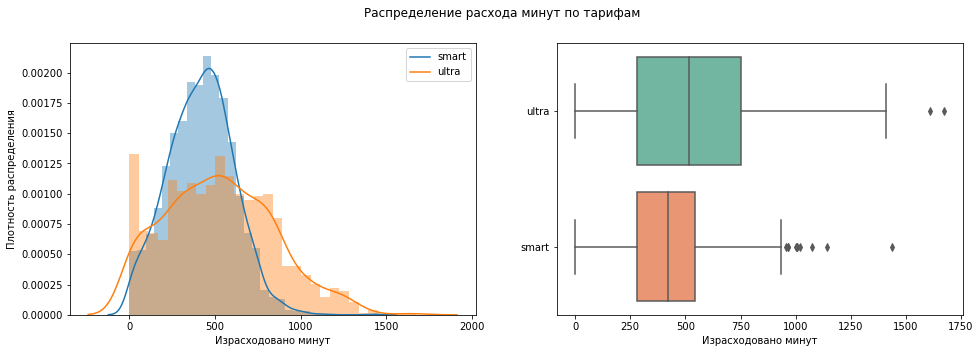

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.distplot(smart_data['calls_duration'], ax=axes[0], bins=30, label='Smart')
sns.distplot(ultra_data['calls_duration'], ax=axes[0], bins=30, label='Ultra')
sns.boxplot(data=megaline_data, x='calls_duration',
            y='tariff', ax=axes[1], palette='Set2')
axes[0].legend(loc='upper right', labels=['smart', 'ultra'])
axes[0].set_xlabel('Израсходовано минут')
axes[1].set_xlabel('Израсходовано минут')
axes[0].set_ylabel('Плотность распределения')
axes[1].set_ylabel(' ')

plt.suptitle('Распределение расхода минут по тарифам')

plt.show()

Расход минут в тарифе Smart от 0 до 950 минут. Больше 950 минут - выбросы. Расход минут в тарифе Ultra от 0 до 1400 минут. Выбросы свыше 1400 минут.

In [34]:
print(f'Разница между средними значениями составляет: {ultra_data["calls_duration"].mean()/smart_data["calls_duration"].mean() - 1:.2%}')

Разница между средними значениями составляет: 25.93%


#### Количество сообщений

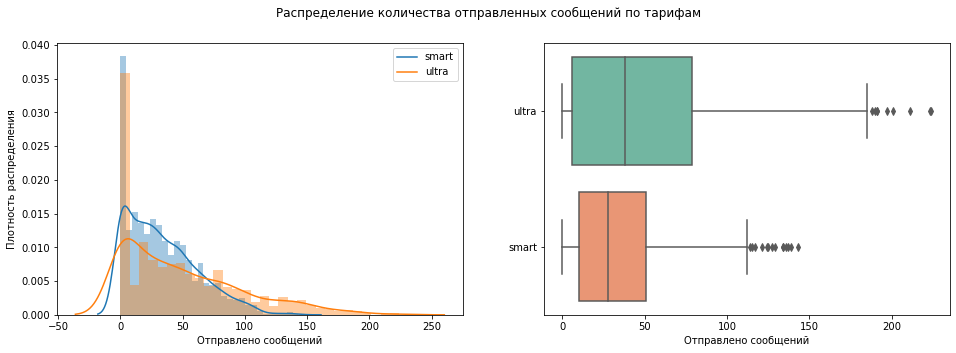

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.distplot(smart_data['messages_quantity'],
             ax=axes[0], bins=30, label='Smart')
sns.distplot(ultra_data['messages_quantity'],
             ax=axes[0], bins=30, label='Ultra')
sns.boxplot(data=megaline_data, x='messages_quantity',
            y='tariff', ax=axes[1], palette='Set2')
axes[0].legend(loc='upper right', labels=['smart', 'ultra'])

axes[0].set_xlabel('Отправлено сообщений')
axes[1].set_xlabel('Отправлено сообщений')
axes[0].set_ylabel('Плотность распределения')
axes[1].set_ylabel(' ')

plt.suptitle('Распределение количества отправленных сообщений по тарифам')

plt.show()

За месяц в тарифе Smart пользователи отправляют от 0 до 115 сообщений. Остальное - выбросы. Расход сообщений в тарифе Ultra от 0 до 180 в месяц. Выбросы свыше 180.

In [36]:
print(f'Разница между средними значениями составляет: {ultra_data["messages_quantity"].mean()/smart_data["messages_quantity"].mean() - 1:.2%}')

Разница между средними значениями составляет: 47.78%


#### Интернет-трафик

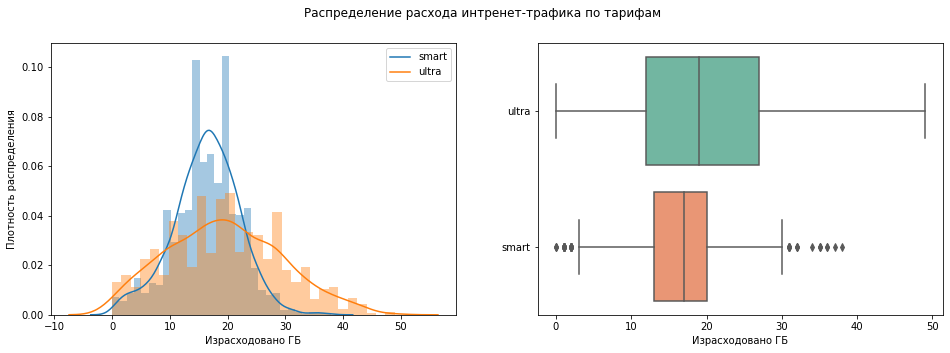

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.distplot(smart_data['gb_used'], ax=axes[0], bins=30, label='Smart')
sns.distplot(ultra_data['gb_used'], ax=axes[0], bins=30, label='Ultra')
sns.boxplot(data=megaline_data, x='gb_used',
            y='tariff', ax=axes[1], palette='Set2')
axes[0].legend(loc='upper right', labels=['smart', 'ultra'])

axes[0].set_xlabel('Израсходовано ГБ')
axes[1].set_xlabel('Израсходовано ГБ')
axes[0].set_ylabel('Плотность распределения')
axes[1].set_ylabel(' ')

plt.suptitle('Распределение расхода интренет-трафика по тарифам')

plt.show()

За месяц в тарифе Smart пользователи расходуют от 3 до 30 ГБ. За этими пределами - выбросы. Расход интернет-трафика в тарифе Ultra от 0 до 49 ГБ в месяц. Выбросов не наблюдается.

In [38]:
print(f'Разница между средними значениями составляет: {ultra_data["gb_used"].mean()/smart_data["gb_used"].mean() - 1:.2%}')

Разница между средними значениями составляет: 19.32%


### Вывод

При сравнении двух тарифов выяснили, что в тарифе Ultra в среднем наблюдается больший расход минут (на 25,93%), сообщений (на 47,78%) и интернет-трафика (на 19,32%). При этом в тарифе Smart расходуют минимум 3 ГБ интернета в месяц, в тарифе Ultra могут не пользоваться интернетом вообще.

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

**Сформулируем нулевую и альтернативную гипотезы**

Есть утверждение, что средняя выручка пользователей тарифов разная, при этом, не уточняется в какую сторону, поэтому нулевую гипотезу сформулируем так: средняя выручка пользователей тарифа Smart равна средней выручке пользователей тарифа Ultra.

В таком случае, альтернативная гипотеза будет звучать так: средняя выручка пользователей тарифа Smart не равна средней выручке пользователей тарифа Ultra.

**Приступим к проверке гипотезы**

Проверим равенство дисперсий тестом Левене.

In [39]:
alpha = .05
stat, p = st.levene(
    smart_data['total_cost'], 
    ultra_data['total_cost']
)
print(f"p-значение:{p}")
if p < alpha:
    print("Дисперсии не равны")
else:
    print("Дисперсии равны")

p-значение:2.3578651290079928e-122
Дисперсии не равны


In [40]:
alpha = .05 # 5% - будем считать, что если равные значения в среднемесячной выручке подтвердятся 
# менее чем в 5% случаев, то это не существенный результат

results = st.ttest_ind(smart_data['total_cost'], ultra_data['total_cost'], equal_var = False)
# так как дисперсии не равны, установим параметр equal_var = False
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.927011394420941e-250
Отвергаем нулевую гипотезу


**Вывод**

Полученное значение p-value говорит о том, что вероятность получить равные значения случайно почти 0,08%. Эта вероятность меньше 1%, поэтому мы можем делать вывод в пользу альтернативной гипотезы о различии между месячной выручкой.

#### Какой тариф лучше?

Выясним, пользователи какого тарифа приносят больше выручки в месяц.

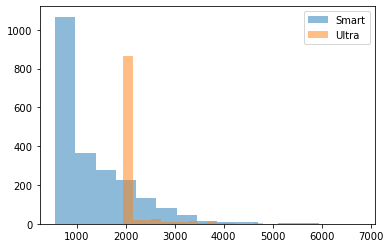

In [41]:
plt.hist(smart_data['total_cost'], bins=15, alpha = 0.5, label='Smart')
plt.hist(ultra_data['total_cost'], bins=15, alpha = 0.5, label='Ultra')
plt.legend(loc='upper right')
plt.show()

In [42]:
print(
    f"Средняя месячная выручка пользователей тарифа Smart: {round(smart_data['total_cost'].mean())}")
print(
    f"Средняя месячная выручка пользователей тарифа Ultra: {round(ultra_data['total_cost'].mean())}")
print(
    f"Разница между месячной выручкой составляет: {smart_data['total_cost'].mean()/ultra_data['total_cost'].mean():.2%}")

Средняя месячная выручка пользователей тарифа Smart: 1290
Средняя месячная выручка пользователей тарифа Ultra: 2070
Разница между месячной выручкой составляет: 62.30%


**Вывод**

Тариф Ultra приносит на 62,30% больше ежемесячной выручки, чем тариф Smart. На основании этих данных можно сделать вывод, что тариф Ultra лучше, так как он прибыльнее для оператора сотовой связи.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

**Сформулируем нулевую и альтернативную гипотезы**

Есть утверждение, что средняя выручка пользователей из Москвы и пользователей из других регионов отличается, при этом, не уточняется в какую сторону, поэтому нулевую гипотезу сформулируем так: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

В таком случае, альтернативная гипотеза будет звучать так: средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.

**Подготовим данные для проверки гипотезы**

Датафрейм с данными по Москве

In [43]:
msk_data = megaline_data.query('city == "Москва"')
len(msk_data)

611

Датафрейм с данными по другим регионам

In [44]:
other_data = megaline_data.query('city != "Москва"')
len(other_data)

2605

**Приступим к проверке гипотезы**

Проверим равнество дисперсий тестом Левене.

In [45]:
alpha = .05
stat, p = st.levene(
    msk_data['total_cost'], 
    other_data['total_cost']
)
print(f"p-значение:{p}")
if p < alpha:
    print("Дисперсии не равны")
else:
    print("Дисперсии равны")

p-значение:0.014015266770621706
Дисперсии не равны


In [46]:
alpha = .05 # 5% - будем считать, что если равные значения в среднемесячной выручке подтвердятся 
# менее чем в 5% случаев, то это не существенный результат

results = st.ttest_ind(msk_data['total_cost'], other_data['total_cost'], equal_var = False)
# так как дисперсии не равны, установим параметр equal_var = False
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Полученное значение p-value говорит о том, что вероятность получить равные значения случайно 52%. Эта вероятность больше 1%, поэтому мы можем сделать предположение о равности месячной выручки между пользователями из Москвы и пользователями из других регионов.

## Общий вывод

В этом проекте был проведен предварительный анализ тарифов федерального оператора сотовой связи «Мегалайн» на небольшой (500 человек) выборке клиентов.Своим клиентам компания предлагает два тарифных плана: «Смарт» и «Ультра». В нашем распоряжении были слудцющие данные пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Задачей исследования было понять, какой тариф приносит больше денег. Мы проанализировали поведение клиентов чтобы сделать вывод — какой тариф лучше.

В ходе исследования удалось выяснить, что пользователи тарифа Ultra в среднем больше расходуют минут (на 25,93%), сообщений (на 47,78%) и интернет-трафика (на 19,32%), по сравнению с пользователями тарифа Smart, что в принципе не удивительно. При этом в тарифе Smart расходуют минимум 3 ГБ интернета в месяц, а в тарифе Ultra могут не пользоваться интернетом вообще.

Но самые важные выводы следующие:

- оба тарифа приносят разную ежемесячную выручку, тариф Ultra приносит на 62,30% больше денег, чем тариф Smart, поэтому тариф Ultra лучше

- существенной разницы в ежемесячной выручке у пользователей из Москвы и пользователей из других регионов не наблюдается